In [116]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model
import pandas as pd
import numpy as np
import math

In [117]:
Target_cell_number = 5e3
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [118]:
def model_S_bispecific(t, z, Ainit, rtot1, rtot2, kon, kon1, k21, k22, koff1, koff2, factor):
    k = Ainit*kon
    k1 = Ainit*kon1
    Atot = factor*1e16*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] - z[2]
    Ag1 = rtot1 - z[0] - z[2]
    Ag2 = rtot2 - z[1] - z[2]

    dA10 = (k*(Ag1)*(A0)/rtot1) - koff1*z[0] - (k22*(Ag2)*z[0]/rtot2) + koff2*z[2]
    dA01 = (k1*(Ag2)*(A0)/rtot2) - koff2*z[1] - (k21*(Ag1)*z[1]/rtot1) + koff1*z[2]
    dA11 = (k22*(Ag2)*z[0]/rtot2) + (k21*(Ag1)*z[1]/rtot1) - (koff1 + koff2)*z[2]

    return [dA10, dA01, dA11]

def myfunc(x, r_tot_pd1, r_tot_ctla4, kon_pd1, kon_ctla4, k2_PD_1, k2_CTLA, koff_pd1, koff_ctla4, factor):
    
    ab_vals = np.zeros_like(x)
    ag1_vals = np.zeros_like(x)
    ag2_vals = np.zeros_like(x)
    
    for i, val in enumerate(x):
        A0 = 1e-9*val

        z = solve_ivp(model_S_bispecific, tspan, z0, method='Radau', t_eval=t, args=(A0, r_tot_pd1, r_tot_ctla4, kon_pd1, 
                                                                                 kon_ctla4, k2_PD_1, k2_CTLA, koff_pd1, koff_ctla4, factor))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_STST = A10[-1]
        A01_STST = A01[-1]
        A11_STST = A11[-1]

        Ag1 = (r_tot_pd1 - A10_STST - A11_STST)/r_tot_pd1
        Ag2 = (r_tot_ctla4 - A01_STST - A11_STST)/r_tot_ctla4
        Ab = 1 - (((r_tot_pd1 - A10_STST - A11_STST) + (r_tot_ctla4 - A01_STST - A11_STST))/(r_tot_pd1 + r_tot_ctla4))

        ab_vals[i] = Ab
        ag1_vals[i] = Ag1
        ag2_vals[i] = Ag2
        

    return ag2_vals


In [119]:
model=Model(myfunc)


df = pd.read_csv('pd1_10_1_data.csv')
x_data_pd1 = np.asarray(df['xdata'])    
y_data = np.asarray(df['ydata'])
y_data_pd1 = y_data/100

df1 = pd.read_csv('ctla4_data_10_1.csv')
x_data_ctla = np.asarray(df1['xdata'])
y_data1 = np.asarray(df1['ydata'])
y_data_ctla = y_data1/100

df2 = pd.read_csv('bispecific_pd1_ctla4_binding_data_10_1.csv')
x_data_ab = np.asarray(df2['xdata'])
y_data2 = np.asarray(df2['ydata'])
y_data_ab = y_data2/100

#print(model.eval(x=1e-9, r_tot_pd1 = 1e5, r_tot_ctla4 = 1e5, kon_pd1 = 1e5, kon_ctla4 = 1e5,
                                            # k2_PD_1 = 1e5, k2_CTLA = 1e5, koff_pd1 = 1e-4, koff_ctla4 = 1e-4, factor=1))

In [120]:
model.set_param_hint('r_tot_pd1', min=0, max = 1e7)
model.set_param_hint('r_tot_ctla4', min=0, max = 1e7)
model.set_param_hint('kon_pd1', min=0, max = 1e7)
model.set_param_hint('kon_ctla4', min=0, max = 1e7)
model.set_param_hint('k2_PD_1', min=0, max = 1e7)
model.set_param_hint('k2_CTLA', min=0, max = 1e7)
model.set_param_hint('koff_pd1', min=0, max = 1e-1)
model.set_param_hint('koff_ctla4', min=0, max = 1e-1)
model.set_param_hint('factor', min=0, max = 100)
params = model.make_params(r_tot_pd1 = 1e5, r_tot_ctla4 = 1e5, kon_pd1 = 1e5, kon_ctla4 = 1e5,
                                             k2_PD_1 = 1e5, k2_CTLA = 1e5, koff_pd1 = 1e-4, koff_ctla4 = 1e-4, factor=1)

result = model.fit(y_data_ab, params, x=x_data_ab)

[[Model]]
    Model(myfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 12
    # variables        = 9
    chi-square         = 3.22010097
    reduced chi-square = 1.07336699
    Akaike info crit   = 2.21407281
    Bayesian info crit = 6.57823266
    R-squared          = -0.65782199
[[Variables]]
    r_tot_pd1:    331711.521 +/- 1.6701e+11 (50349444.89%) (init = 100000)
    r_tot_ctla4:  48.8088300 +/- 8.1695e+08 (1673784874.56%) (init = 100000)
    kon_pd1:      9726646.16 +/- 3.1812e+12 (32706070.11%) (init = 100000)
    kon_ctla4:    1341494.88 +/- 4.0875e+10 (3046985.69%) (init = 100000)
    k2_PD_1:      7986898.13 +/- 4.0917e+14 (5123059679.97%) (init = 100000)
    k2_CTLA:      449243.463 +/- 1.1944e+13 (2658677228.02%) (init = 100000)
    koff_pd1:     0.01868431 +/- 162570.904 (870092985.75%) (init = 0.0001)
    koff_ctla4:   0.03391158 +/- 150706.007 (444408623.60%) (init = 0.0001)
    factor:       86.4400422 +/- 2

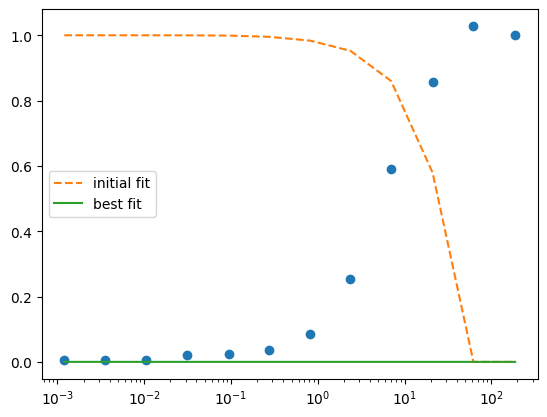

In [122]:
print(result.fit_report())

plt.plot(x_data_ab, y_data_ab, 'o')
plt.plot(x_data_ab, result.init_fit, '--', label='initial fit')
plt.plot(x_data_ab, result.best_fit, '-', label='best fit')
plt.legend()
plt.xscale('log')
plt.show()